<a href="https://colab.research.google.com/github/suhayb-h/Acute-Lymphoblastic-Leukemia-Classifier/blob/main/1_ALL_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acute Lymphoblastic Leukemia Classifier:
## Notebook 1: Preprocessing and Exploratory Data Analysis
##### Project Author: Suhayb Hafiz 

---

## Introduction

The primary purpose of this project was to serve as an academic review to assess the viability of computer-assisted diagnostic tools for pathologies with morphological changes on a cellular level. Specifically, the goal was to assess whether machine learning and neural network models could be used to differentiate cells based on the presence of seemingly imperceptable differences. On November 10, 2018, the C-NMC challenge was opened to the public and was closed on March 18, 2019.$^1$ All teams involved in this competition were tasked with creating a machine learning-based classifier that would accurately differentiate normal B-lymphoblast cells from Acute Lymphoblastic Leukemia (ALL) cells.$^2$ The dataset provided for this challenge, named C-NMC 2019 Dataset, was prepared at Laboratory Oncology, AIIMS, located in New Delhi, India.$^3$ It consisted of B-lymphoblast images, labelled 'all' (cancerous) and 'hem' (normal). The dataset is still publicly available at The Cancer Imaging Archive and is split into a training set and a testing set.$^4$ The training set consists of 12528 cell images collected from the data of 60 cancer subjects and 41 healthy subjects.$^5$ Testing data consisted of 2586 cell images collected from 9 cancer subjects and 8 healthy subjects.$^6$ Of the 251 participating teams, 15 machine-learning models were formally presented and the unique differences between these models will be outlined in this report.

The secondary purpose of this project was to create three new models in an attempt to better understand what adjustments could be made to improve performance metrics of cellular classifier models. The first model is a single layer, untrainable, neural network that would serve as a baseline logistic regression model. The second model added two layers to allow for training. The third model trained the dataset on a complex ResNet50 V2 model.

Acute Lymphoblastic Leukemia (ALL) is the most common type of childhood cancer, accounting for approximately 25% of pediatric neoplasias. ALL is caused by the excessive proliferation of a subclassification of immature white blood cells called B-Lymphoblasts.B-Lymphoblasts are immature cells that mature within bone marrow. Once fully matured, these cells become B-Lymphocytes and are ultimately responsible for producing antibodies in addition to other roles within the immune system. 

Hopefully, building cellular classifiers can serve as tools that can augment diagnostic medical imaging. Such advancements could result in ealier diagnosis for a larger number of diseases and conditions, resulting in positive influence on prognosis and patient outcome. 

## Data Collection and Pre-Processing

Images for this project were released to the public for the International Symposium on Biomedical Imaging (ISBI) 2019 C-NMC Challenge. This challenge was an international competition that culminated in a symposium in Venice, Italy. The cells were collected through bone marrow biopsies from 69 patients suffering from ALL and 49 patients without ALL. For this project, these files were downloaded directly from Kaggle.

The dataset provided was relatively small, accounting for a total of only 15,135 images of lymphoblasts. Furthermore, there were no labels provided for the "test" data folder, deeming them completely unusable for this project. As a result, only 12,528 images were available for analysis. To adapt to this shortcoming, the validation data folder provided in the original dataset was used as the test set. Within the code for each model, new validation data was provided directly from the training set. 

For the models detailed as part of this project, dealing with even this relatively small dataset proved challenging due to the lack of computational resources available. Training took a remarkably long time, with the longest training time being 33 hours, while other models would fail to complete training altogether. The most significant means of combatting this issue was by importing the images through a data generator. 

The original validation dataset was structured entirely differently from the training dataset. While the training folder had ALL and normal lymphoblasts divided into subfolders, the validation folder had 1867 lymphocyte images within a single folder with an accompanying CSV file that labelled these cells as 'all' or normal ('hem'). After importing  relevent libraries for this notebook, this dataframe is shown below: 

In [ ]:
# This notebook was written google co-lab
# This code cell should not be run if not using co-lab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import glob as glob
import os
import random
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as img
%matplotlib inline
from sklearn.utils import shuffle

In [ ]:
# For author: Code to run locally
# df_test = pd.read_csv("/content/drive/Othercomputers/My MacBook Air/BrainStation/Capstone/capstone_data/test_data/val_data.csv", dtype = str)

# For author: Code to run on co-lab
df_test = pd.read_csv("/content/drive/Othercomputers/My MacBook Air/BrainStation/Capstone/capstone_data/test_data/val_data.csv", 
                      dtype = str) #<-- Dataframe had to be formatted as strings to be compatible with the data generator
df_test

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1
...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1
1863,UID_55_24_1_all.bmp,1864.bmp,1
1864,UID_H32_20_1_hem.bmp,1865.bmp,0
1865,UID_54_30_2_all.bmp,1866.bmp,1


With regards to the dataframe shown above, an issue arose with the labelling. When training neural networks, the machine defaulted labelling 'all' as '0'and 'hem' as '1'. This was the opposite of the labelling that was used in the CSV shown above. For this reason, a new column was added to the dataframe called `true_labels` before running test data through trained models. This adjustment was included in the cell below:

In [ ]:
# a new column called true_labels was created wherein 'all' patients are labelled 0 
df_test.loc[df_test['Patient_ID'].str.contains('all'), 'true_labels'] = '0'

# true_labels was also given a label 1 for any patients that were non-cancerous
df_test.loc[df_test['Patient_ID'].str.contains('hem'), 'true_labels'] = '1'

df_test

,Patient_ID,new_names,labels,true_labels
0,UID_57_29_1_all.bmp,1.bmp,1,0
1,UID_57_22_2_all.bmp,2.bmp,1,0
2,UID_57_31_3_all.bmp,3.bmp,1,0
3,UID_H49_35_1_hem.bmp,4.bmp,0,1
4,UID_58_6_13_all.bmp,5.bmp,1,0
...,...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1,0
1863,UID_55_24_1_all.bmp,1864.bmp,1,0
1864,UID_H32_20_1_hem.bmp,1865.bmp,0,1
1865,UID_54_30_2_all.bmp,1866.bmp,1,0


## Data Exploration

This notebook was created with the purpose of analyzing images of cells that were contained within the original dataset. The first step was to assess whether these images could be found and categorized within the code, based on folder structure and organization. This process was conducted in the cell below: 

In [ ]:
# Re-structuring the training directory prior to running any further cells is required
# Instructions for re-structuring are found in README file

data = \
tf.keras.utils.\
image_dataset_from_directory('/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data', # --> Training set directory path
                             labels = "inferred", # --> Labels are extracted directly from folder names from directory
                             class_names=['all', 'hem']) # --> Class names need to be identical to folder names or errors will result

Found 10661 files belonging to 2 classes.


The machine was able to correctly identify 10,661 images as part of the training dataset. It is useful to be able to visualize these images directly within this notebook. Below is an assortment of 15 cells from the dataset with their appropriate labels. 

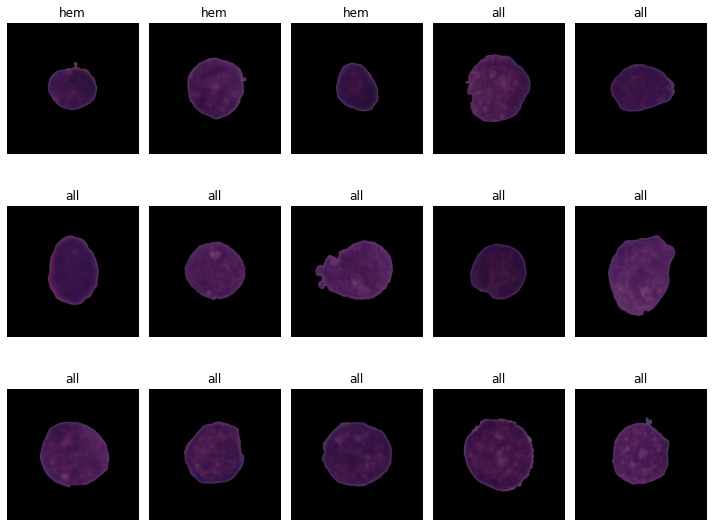

In [ ]:
# Re-Running this code gives a new assortment of 15 cells labelled as either normal lymphoblasts (hem) or cancerous lymphoblasts (all)

class_names = data.class_names

plt.figure(figsize=(10, 8))
for images, labels in data.take(1):
  for i in range(15): # --> Plot 15 images 
    ax = plt.subplot(3, 5, i + 1) # --> Index starts from 0; +1 needed to plot each image
    plt.imshow(images[i].numpy().astype("uint8")) # --> Integer conversion needed to display images
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()

B-Lymphocytes develop and mature within bone marrow as immature B-lymphoblasts. Typically, bone marrow samples are collected and visualized through a microscope, which allows pathologists and other medical professionals to visualize a multitude of different cell types. This dataset is unique in that lymphoblasts found within pictures of bone marrow smears were isolated from the rest of the image and normalized on a black background. This is a relatively novell imaging technique that isn't typically used in a clinical setting, but can provide benefit in medical research. This imaging technique is especially useful in the context of machine learning and neural networks since the models are exclusively trained on the lymphoblast images themselves and are unaffected by any other noise.

Cycling through random assortments of 15 images of lymphoblasts showcases the similarity between normal lymphoblasts and cancerous lymphoblasts. Immature cells throughout the body typically have large nuclei which allows for increased cell transcription and division. Closer inspection might reveal that cancerous lymphoblasts tend to be marginally larger and have more colour variation. However, these rules aren't followed by every image.

#### Lymphoblast Size Analysis

There are analytical techniques that can be utilized to assess whether there are truly changes in colour distribution and size between healthy lymphoblasts and cancerous lymphoblasts. Utilizing data manipulation techniques prior to machine modelling can provide useful insights as to what constitutes the differences between these two cell groups. In order to accomplish this task, an average of every "all" cancer image was created to compare to an average of normal lymphoblasts. In this notebook, images were interpreted as matrices that could be plotted as graphs. In essence, an image is nothing more than a matrix that holds RGB coordinates.  To create an average of images, every individual matrix for each image was combined into a single giant matrix. One giant matrix was created for normal cells (called `hem_`) and one for cancerous cells (called `all_`). These steps are listed below:

In [ ]:
hem_ = []

#For original author: Code to run locally
#for i in glob.glob('/C-NMC_Leukemia/training_data/hem/*.bmp'):
#   im=img.imread(i)
#   hem_.append(im)

# For original author: Code to run on co-lab
for i in glob.glob(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data/hem/*.bmp'):
    im=img.imread(i)
    hem_.append(im)

hem_array = np.array(hem_)

In [ ]:
all_ = []

#For original author: Code to run locally
#for i in glob.glob('/C-NMC_Leukemia/training_data/all/*.bmp'):
#   im=img.imread(i)
#   all_.append(im)

# For original author: Code to run on co-lab
for i in glob.glob(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data/all/*.bmp'):
    im=img.imread(i)
    all_.append(im)

all_array = np.array(all_)

Every image is appended to the giant matrix as a new layer. By assessing the shape of these matrices, new information can be discerned about the image data.

In [ ]:
hem_array.shape

(3389, 450, 450, 3)

In [ ]:
all_array.shape

(7272, 450, 450, 3)

The shapes of the above arrays reveal that all images in the dataset are 450 pixels by 450 pixels. The '3' in these matrices represents the three RGB colours. Assessing the shapes of both aformentioned arrays showcases the distribution of the dataset. There is an obvious imbalance in the dataset, since only 3,389 images are classified as normal cells and 7,272 images are cancerous. From a clinical context, this imbalance makes sense. Bone marrow extraction is an exceptionally painful and invasive procedure. Physicians are unlikely to order a bone marrow biopsy unless there is significant evidence that the patient might be suffering from cancer. As such, imbalance is to be expected, as the majority of bone marrow biopsies should reveal cancerous disease.

However, this imbalance can prove to be an issue during modelling. To address this issue, data could have been manipulated by randomly isolating half of cancerous images, in order to establish a relatively even number of images to compare between cancerous and non-cancerous states. However, this technique was ultimately decided against since having less data could also prove detrimental to model performance and reliability. For the purposes of this project, every image was utilized in model training. Instead of removing images, every neural network was assigned "weights" which allowed for normal cellular images to be assigned the weight of two cancerous cell images.
These giant matrices were plotted as images below and are representative of the average of each cell class:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


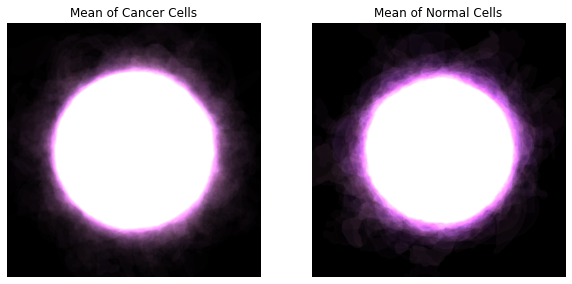

In [ ]:
# Created a subplot of two images next to each other

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(all_array.mean(axis=0))
plt.title("Mean of Cancer Cells")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hem_array.mean(axis=0))
plt.title("Mean of Normal Cells")
plt.axis("off")
plt.show()

Some interesting observations between both classes of cells can be made based on the images above. In terms of similarities, the core of both of these images are bright white in colour. This makes sense, since every cell image in this dataset had varying presentations of the colours within the cell. Taking the average of several images cause these variations to cancel each other out, resulting in a uniform white colour.
In terms of differences between these images, there are two significant observations. Firstly, the average cancer cell appears relatively large compared to the non-cancer image. The current understanding of cancer is that neoplastic cells are typically large to facilitate constant growth resutling in increased cell division. 
Additionally, the average cancer cell had a 'thinner' membrane compare to a non-cancer cell. This isn't necessarily a reflection of the thickness in cell membranes, but rather a reflection of average cell size. Immature cells, such as lymphoblasts, are already in a state of growth which requires relatively large nuclei. Cancer cells will be significantly more transcriptionally active compared to non-cancer lymphoblasts, which simply means that there will be more DNA replication for eventual protein synthesis. More transcription requires more DNA replication proteins, which takes up space. DNA replication almost exclusively occurs in the nucleus, which is why neoplastic cells should have larger nuclei. The result of larger nuclei, represented by the white space in our two images, is that cancer cells will typically have less space between their outer cell membrane and their nuclear envelope. 

#### Lymphoblast Colour Distribution

Based on the difference in the average cell size, machine learning models might be able to predict cancerous cells with a high degree of accuracy. Size and thickness of boundaries are two features that are typically easily discernable by various machine learning models. Furthermore, the high variation in thickness in the normal cell class might also result in a higher representation of colours, which is another feature that is typically easily identified by machine learning models. Isolating a small portion of both cells can allow for the comparison of their colour distributions. Comparing a small portion of the two cell stacks will allow for a better representation of the distribution of eosin (pink) colours. This technique would also allow for prevent eosin colours from being significantly outweighed by the black and white hues which make up a majority of the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


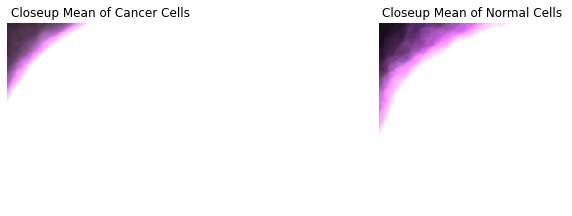

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(all_array[:,100:250,100:250].mean(axis=0))
plt.title("Closeup Mean of Cancer Cells")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hem_array[:,100:250,100:250].mean(axis=0))
plt.title("Closeup Mean of Normal Cells")
plt.axis("off")

plt.subplots_adjust(wspace=1) 
plt.show()

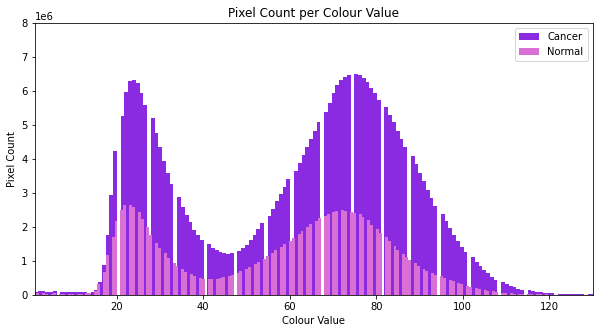

In [ ]:
plt.figure(figsize = (10, 5))
plt.hist(np.ravel(all_array[:,100:250,100:250]), bins=256, label = 'Cancer', color = 'blueviolet')
plt.hist(np.ravel(hem_array[:,100:250,100:250]), bins=256, label = 'Normal', color = 'orchid')
plt.ylim(0,8000000) # --> set the y limit to zoom in on the y axis to better display difference
plt.xlim(1,130) # --> set the X limit to only show the portion of the graph that shows difference
plt.xlabel('Colour Value')
plt.ylabel('Pixel Count')
plt.legend(loc='upper right')
plt.title('Pixel Count per Colour Value')
plt.show()

The above graph reveals a surpising finding, being that the cancer cell somehow showcases a more expansive colour distribution when compared to normal lymphoblasts. This is peculiar, and might require further biological testing to better understand why the cancer cell membrane might be showcasing a larger variation in colour. 

## Conclusion

A lot was surmised from the initial exploratory data analysis and this concludes this notebook. The exploration of the dataset revealed that cancer cells are larger and might display a higher colour density than normal cells. Based on these features, certain machine learning models have the potential to perform well in diagnosing lymphoblasts as normal or cancerous.

The next notebook details an initial logistic regression model and a simple convolutional neural network. The notebook will train these models on the image data and reveal their respective performances.